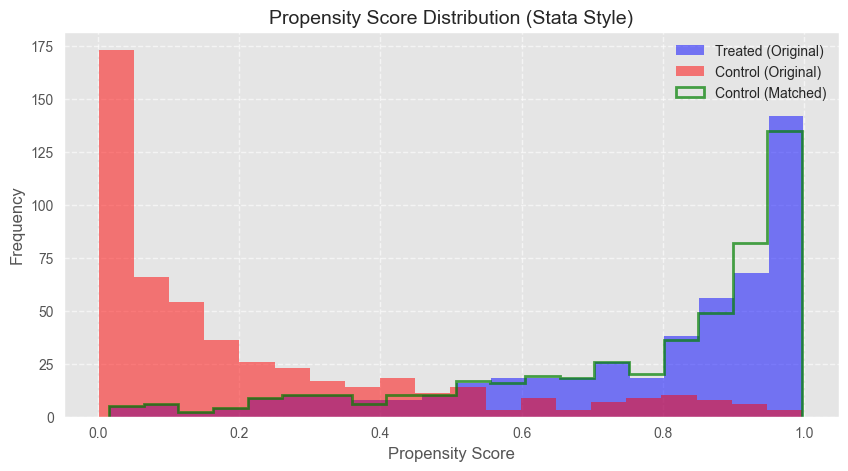

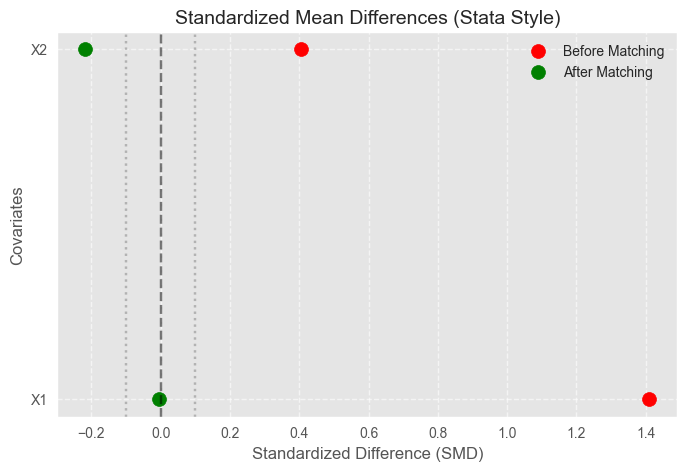


Balance Diagnostics (Stata Style):
  Variable  Mean_Treated  Mean_Control_Pre  Mean_Control_Post  SMD_Pre  \
0       X1        0.7195           -0.6913             0.7253   1.4101   
1       X2        0.2074           -0.1992             0.4247   0.4064   

   SMD_Post  
0   -0.0058  
1   -0.2172  
Note: Absolute SMD < 0.1 indicates good balance

Sample Sizes After Matching:
Original Treated:          490
Original Control:          510
Matched Control:           490
Total Matched:             980


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# Set Stata-style plotting
plt.style.use('ggplot')
sns.set_palette("Set1")

# Generate simulated data
np.random.seed(42)
n = 1000
data = pd.DataFrame({
    'X1': np.random.normal(0, 1, n),
    'X2': np.random.normal(5, 2, n),
    'T': np.random.choice([0, 1], size=n)
})

# Create systematic differences
data.loc[data['T'] == 1, 'X1'] += 2
data.loc[data['T'] == 0, 'X2'] -= 1

# Standardize covariates
scaler = StandardScaler()
data[['X1', 'X2']] = scaler.fit_transform(data[['X1', 'X2']])

# Estimate propensity scores
model = LogisticRegression()
model.fit(data[['X1', 'X2']], data['T'])
data['ps'] = model.predict_proba(data[['X1', 'X2']])[:, 1]

# Nearest neighbor matching
nn = NearestNeighbors(n_neighbors=1)
nn.fit(data[data['T'] == 0][['ps']])
distances, indices = nn.kneighbors(data[data['T'] == 1][['ps']])
matched_control = data[data['T'] == 0].iloc[indices.flatten()]

# =============================================
# Stata-style Visualizations
# =============================================

# 1. Propensity Score Distribution (like Stata's psgraph)
plt.figure(figsize=(10, 5))
plt.hist(data[data['T']==1]['ps'], bins=20, alpha=0.5, color='b', label='Treated (Original)')
plt.hist(data[data['T']==0]['ps'], bins=20, alpha=0.5, color='r', label='Control (Original)')
plt.hist(matched_control['ps'], bins=20, alpha=0.7, color='g', 
         histtype='step', linewidth=2, label='Control (Matched)')
plt.title('Propensity Score Distribution (Stata Style)', fontsize=14)
plt.xlabel('Propensity Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 2. Standardized Mean Differences (like Stata's loveplot)
def calculate_smd(var):
    t_mean = data[data['T']==1][var].mean()
    c_mean_pre = data[data['T']==0][var].mean()
    c_mean_post = matched_control[var].mean()
    pooled_std = data[var].std()
    smd_pre = (t_mean - c_mean_pre) / pooled_std
    smd_post = (t_mean - c_mean_post) / pooled_std
    return smd_pre, smd_post

smd_x1_pre, smd_x1_post = calculate_smd('X1')
smd_x2_pre, smd_x2_post = calculate_smd('X2')

variables = ['X1', 'X2']
smd_pre = [smd_x1_pre, smd_x2_pre]
smd_post = [smd_x1_post, smd_x2_post]

plt.figure(figsize=(8, 5))
plt.scatter(smd_pre, variables, color='r', s=100, label='Before Matching')
plt.scatter(smd_post, variables, color='g', s=100, label='After Matching')
plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.axvline(x=0.1, color='gray', linestyle=':', alpha=0.5)
plt.axvline(x=-0.1, color='gray', linestyle=':', alpha=0.5)
plt.title('Standardized Mean Differences (Stata Style)', fontsize=14)
plt.xlabel('Standardized Difference (SMD)', fontsize=12)
plt.ylabel('Covariates', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 3. Balance Table (like Stata's pstest)
balance_table = pd.DataFrame({
    'Variable': ['X1', 'X2'],
    'Mean_Treated': [data[data['T']==1]['X1'].mean(), data[data['T']==1]['X2'].mean()],
    'Mean_Control_Pre': [data[data['T']==0]['X1'].mean(), data[data['T']==0]['X2'].mean()],
    'Mean_Control_Post': [matched_control['X1'].mean(), matched_control['X2'].mean()],
    'SMD_Pre': [smd_x1_pre, smd_x2_pre],
    'SMD_Post': [smd_x1_post, smd_x2_post]
})

print("\nBalance Diagnostics (Stata Style):")
print("="*65)
print(balance_table.round(4))
print("="*65)
print("Note: Absolute SMD < 0.1 indicates good balance")

# Calculate and print sample sizes
original_treated = data[data['T']==1].shape[0]
original_control = data[data['T']==0].shape[0]
matched_control = matched_control.shape[0]

print("\nSample Sizes After Matching:")
print("="*40)
print(f"{'Original Treated:':<20}{original_treated:>10}")
print(f"{'Original Control:':<20}{original_control:>10}")
print(f"{'Matched Control:':<20}{matched_control:>10}")
print(f"{'Total Matched:':<20}{(original_treated + matched_control):>10}")
print("="*40)